<a href="https://colab.research.google.com/github/Guhan2348519/dl-lab-tasks/blob/main/2348519_DL_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score,f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageFilter
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model




In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths to your folders
folder_path = r"C:\Users\Guhan\Desktop\christ\New folder\tubercolsis\TB_Chest_Radiography_Database"
normal_path = os.path.join(folder_path, "normal")
tuberculosis_path = os.path.join(folder_path, "tuberculosis")
destination_path = r"C:\Users\Guhan\Desktop\christ\New folder\tubercolsis\TB_Chest_Radiography_Database"

# Split normal images into train and test sets
normal_images = os.listdir(normal_path)
train_normal, test_normal = train_test_split(normal_images, test_size=0.2, random_state=42)

# Create train and test directories in destination folder
train_dest_path = os.path.join(destination_path, "train", "normal")
test_dest_path = os.path.join(destination_path, "test", "normal")
os.makedirs(train_dest_path, exist_ok=True)
os.makedirs(test_dest_path, exist_ok=True)

# Move normal images to train directory
for image in train_normal:
    src = os.path.join(normal_path, image)
    dest = os.path.join(train_dest_path, image)
    shutil.copy(src, dest)

# Move normal images to test directory
for image in test_normal:
    src = os.path.join(normal_path, image)
    dest = os.path.join(test_dest_path, image)
    shutil.copy(src, dest)

# Split tuberculosis images into train and test sets
tuberculosis_images = os.listdir(tuberculosis_path)
train_tuberculosis, test_tuberculosis = train_test_split(tuberculosis_images, test_size=0.2, random_state=42)

# Create train and test directories in destination folder
train_dest_path = os.path.join(destination_path, "train", "tuberculosis")
test_dest_path = os.path.join(destination_path, "test", "tuberculosis")
os.makedirs(train_dest_path, exist_ok=True)
os.makedirs(test_dest_path, exist_ok=True)

# Move tuberculosis images to train directory
for image in train_tuberculosis:
    src = os.path.join(tuberculosis_path, image)
    dest = os.path.join(train_dest_path, image)
    shutil.copy(src, dest)

# Move tuberculosis images to test directory
for image in test_tuberculosis:
    src = os.path.join(tuberculosis_path, image)
    dest = os.path.join(test_dest_path, image)
    shutil.copy(src, dest)


In [ ]:
def preprocess_images(train_dir, test_dir, target_size=(224, 224), batch_size=32, augmentation=False, test_size=0.2):
    # ImageDataGenerator for loading and preprocessing images
    if augmentation:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
    else:
        datagen = ImageDataGenerator()

    # Flow images from directories in batches
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)  # Assuming classification task

    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)  # No need to shuffle test data

    return train_generator, test_generator

# Example usage
train_dir = 'train'
test_dir = 'test'

train_generator, test_generator = preprocess_images(train_dir, test_dir, augmentation=True)


Found 1120 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


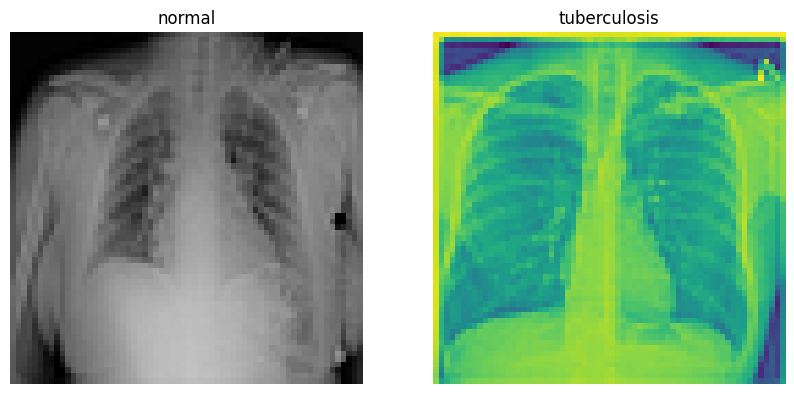

In [ ]:
# Define the directory paths for the training and testing sets
training_dir = 'Train'
testing_dir = 'Test'

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Function to display one resized and sharpened image of each class in a given directory in a horizontal layout
def display_one_resized_sharpened_image_per_class_horizontal(directory, class_labels, target_size=(64, 64)):
    fig, axes = plt.subplots(1, len(class_labels), figsize=(10, 10))

    for i, label in enumerate(class_labels):

        class_path = os.path.join(directory, label)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_path = os.path.join(class_path, images[0])  # Select the first image for each class

        img = Image.open(img_path)
        img = img.resize(target_size)


        # Apply a sharpening filter
        img = img.filter(ImageFilter.SHARPEN)

        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.show()
# Display one resized and sharpened image for each class in the testing set in a horizontal layout
display_one_resized_sharpened_image_per_class_horizontal(testing_dir, class_labels)


In [ ]:
# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(224, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=5, validation_data=test_generator)

# Evaluate the model
accuracy = model.evaluate(test_generator)[1]
print("Test Accuracy:", accuracy)

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.6799 - loss: 1.0121 - val_accuracy: 0.9464 - val_loss: 0.1687
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9614 - loss: 0.1155 - val_accuracy: 0.9536 - val_loss: 0.1396
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9592 - loss: 0.1153 - val_accuracy: 0.9679 - val_loss: 0.1098
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9775 - loss: 0.0769 - val_accuracy: 0.9571 - val_loss: 0.1039
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.9729 - loss: 0.0789 - val_accuracy: 0.9714 - val_loss: 0.0923
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9732 - loss: 0.0754
Test Accuracy: 0.9714285731315613


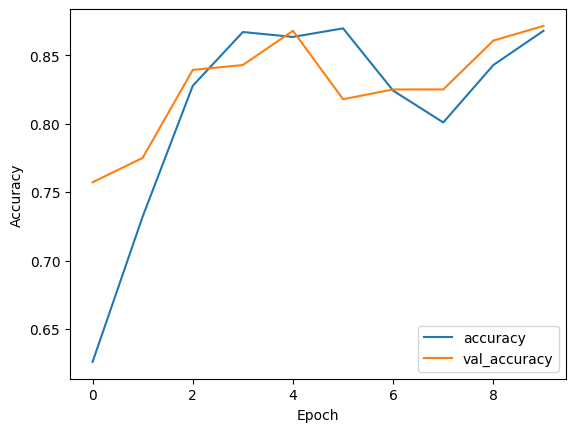

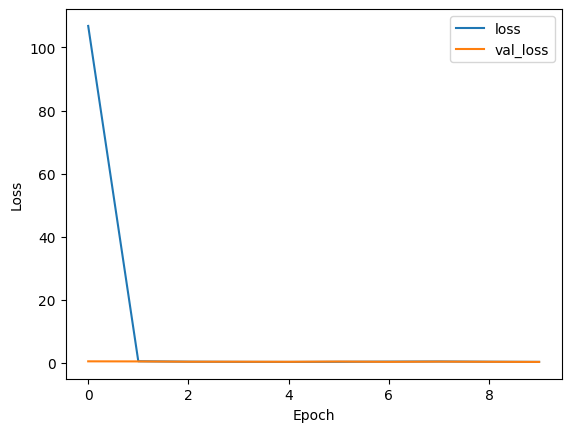

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

def build_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Define input shape and number of classes
input_shape =(224, 224, 3)   # Update the input shape
num_classes = 2  # Number of classes for binary classification

# Build the custom CNN model
model = build_custom_cnn(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you have defined train_generator and test_generator
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

# Print model summary
model.summary()


Epoch 1/10


C:\Users\Guhan\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5403 - loss: 313.6087 - val_accuracy: 0.7571 - val_loss: 0.4852
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7597 - loss: 0.4733 - val_accuracy: 0.7750 - val_loss: 0.4587
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7899 - loss: 0.4302 - val_accuracy: 0.8393 - val_loss: 0.3682
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8575 - loss: 0.3231 - val_accuracy: 0.8429 - val_loss: 0.3663
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8566 - loss: 0.2910 - val_accuracy: 0.8679 - val_loss: 0.3408
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8790 - loss: 0.3047 - val_accuracy: 0.8179 - val_loss: 0.4184
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8287 - loss: 0.3854 - val_accuracy: 0.8250 - val_loss: 0.3306
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7774 - loss: 0.4672 - val_accuracy: 0.8250 - val_loss: 0.3928
E

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,656 (127.82 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,438 (85.21 MB)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

def build_custom_cnn(input_shape, num_classes, learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(224, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compiling the model with custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Defining input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2
learning_rate = 0.001

model = build_custom_cnn(input_shape, num_classes, learning_rate)
history = model.fit(train_generator, epochs=5, validation_data=test_generator)
model.summary()


Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.6912 - loss: 7.4494 - val_accuracy: 0.5000 - val_loss: 135.5203
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.8068 - loss: 3.0019 - val_accuracy: 0.5393 - val_loss: 10.3222
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.8358 - loss: 0.7956 - val_accuracy: 0.7143 - val_loss: 2.1817
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.8186 - loss: 0.6838 - val_accuracy: 0.5107 - val_loss: 7.9326
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.8448 - loss: 0.5986 - val_accuracy: 0.7571 - val_loss: 0.6083


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 224)            │    19,382,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,430,376 (222.89 MB)

 Trainable params: 19,476,642 (74.30 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 38,953,286 (148.59 MB)

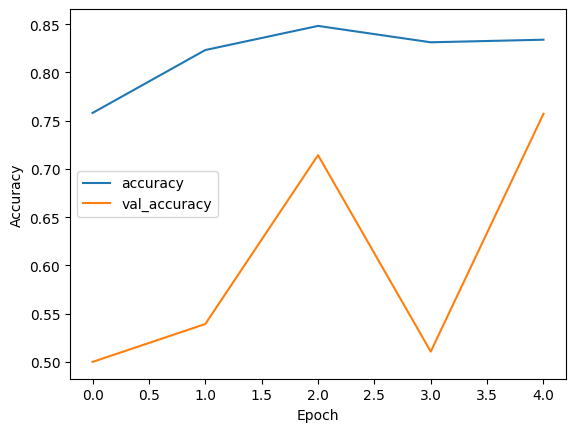

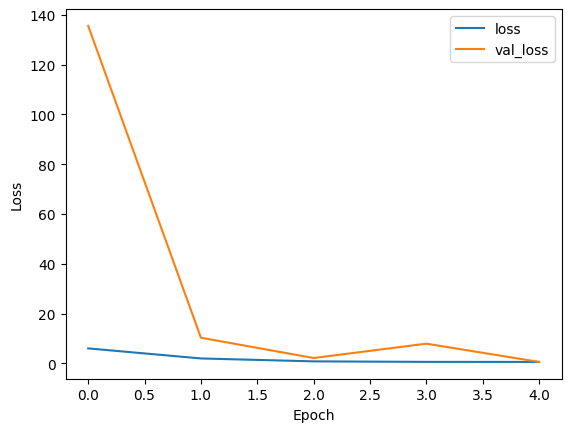

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
import cv2
import numpy as np

# Read and preprocess your image
img = cv2.imread(r"train\tuberculosis\Tuberculosis-1.png")
img = cv2.resize(img, (224, 224))

# Display the image
cv2.imshow('Image', img)


img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize the image

preds = model.predict(img)

# Get the predicted class index
predicted_class_index = np.argmax(preds)

# Mapping predicted index to class label
class_indices = train_generator.class_indices
predicted_class_label = list(class_indices.keys())[predicted_class_index]

print("Predicted class:", predicted_class_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted class: tuberculosis
